# Optimal Realized Volatility Prediction

This notebook contains some techniques of modeling process. If you are interested in EDA of this data, please check [here](https://www.kaggle.com/hyewon328/understand-and-visualize-volatility-data)!

## Process
1. [Preprocessing](#pre)
2. [Feature Selection](#fs)
3. [Bayesian Optimization](#opt)
4. [Modeling](#model)
5. [Prediction & Submission](#pred)

# Load package & data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob
from joblib import Parallel, delayed

import eli5
from eli5.sklearn import PermutationImportance
from bayes_opt import BayesianOptimization

from tqdm import tqdm
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv")
test = pd.read_csv("../input/optiver-realized-volatility-prediction/test.csv")
sub = pd.read_csv("../input/optiver-realized-volatility-prediction/sample_submission.csv")

In [3]:
book_train_filepath = "/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet"
trade_train_filepath = "/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet"
book_test_filepath = "/kaggle/input/optiver-realized-volatility-prediction/book_test.parquet"
trade_test_filepath = "/kaggle/input/optiver-realized-volatility-prediction/trade_test.parquet"

# get filenames in book and trade files
book_train_filenames = os.listdir(book_train_filepath)
trade_train_filenames = os.listdir(trade_train_filepath)
book_test_filenames = os.listdir(book_test_filepath)
trade_test_filenames = os.listdir(trade_test_filepath)

## Data Preprocessing <a class="anchor" id="pre"></a>

In **preprocessing part**, we generate some additional variables for LGBM Modeling.

Reference:
<https://www.kaggle.com/manels/lgb-starter>

In [4]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def RMSPE(true, pred):
    rmspe = np.sqrt(np.mean(np.square((true-pred)/true)))
    return rmspe

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(RMSPE(true = labels, pred = preds),5), False

In [5]:
def pre_data(stock_id, train = True):
    
    if train == True:
        book_filepath = book_train_filepath
        trade_filepath = trade_train_filepath
    else:
        book_filepath = book_test_filepath
        trade_filepath = trade_test_filepath
    
    path = os.path.join(book_filepath, f"stock_id={stock_id}".format(stock_id))
    data = pd.read_parquet(path)
    data['stock_id'] = stock_id
    
    data['wap1'] = (data['bid_price1'] * data['ask_size1'] + data['ask_price1'] * data['bid_size1']) / (data['bid_size1']+ data['ask_size1'])
    data['wap2'] = (data['bid_price2'] * data['ask_size2'] + data['ask_price2'] * data['bid_size2']) / (data['bid_size2']+ data['ask_size2'])
    data['log_return1'] = data.groupby(['time_id'])['wap1'].apply(log_return)
    data['log_return2'] = data.groupby(['time_id'])['wap2'].apply(log_return)
    data = data[~data['log_return1'].isnull()]
    data = data[~data['log_return2'].isnull()]
    
    data['spread1'] = data['ask_price1'] - data['bid_price1']
    data['spread2'] = data['ask_price2'] - data['bid_price2']
    data['net_size1'] = data['bid_size1'] - data['ask_size1']
    data['net_size2'] = data['bid_size2'] - data['ask_size2']
    
    book_data = data.groupby(['stock_id', 'time_id']).agg(max_wap1 = ('wap1', 'max'),
                                                          max_wap2 = ('wap2', 'max'),
                                                          min_wap1 = ('wap1', 'min'),
                                                          min_wap2 = ('wap2', 'min'),
                                                          max_log_return1 = ('log_return1', 'max'),
                                                          max_log_return2 = ('log_return2', 'max'),
                                                          min_log_return1 = ('log_return1', 'min'),
                                                          min_log_return2 = ('log_return2', 'min'),
                                                          mean_wap1 = ('wap1', 'mean'),
                                                          mean_wap2 = ('wap2', 'mean'),
                                                          max_spread1 = ('spread1', 'max'),
                                                          max_spread2 = ('spread2', 'max'),
                                                          min_spread1 = ('spread1', 'min'),
                                                          min_spread2 = ('spread2', 'min'),
                                                          mean_spread1 = ('spread1', 'mean'),
                                                          mean_spread2 = ('spread2', 'mean'),
                                                          max_netsize1 = ('net_size1', 'max'),
                                                          max_netsize2 = ('net_size2', 'max'),
                                                          min_netsize1 = ('net_size1', 'min'),
                                                          min_netsize2 = ('net_size2', 'min'),
                                                          mean_netsize1 = ('net_size1', 'mean'),
                                                          mean_netsize2 = ('net_size2', 'mean')).reset_index()
    
    #volatility = data.groupby(['stock_id', 'time_id'])['log_return1', 'log_return2'].agg(realized_volatility).reset_index()
    #volatility.rename(columns = {'log_return1': 'volatility1', 'log_return2': 'volatility2'}, inplace = True)


    trade_path = os.path.join(trade_filepath, f"stock_id={stock_id}".format(stock_id))
    trade_data = pd.read_parquet(trade_path)
    trade_data['stock_id'] = stock_id
    
    trade_data = trade_data.groupby(['stock_id', 'time_id']).agg(max_price = ('price', 'max'),
                                                     min_price = ('price', 'min'),
                                                     mean_price = ('price', 'mean'),
                                                     max_size = ('size', 'max'),
                                                     min_size = ('size', 'min'),
                                                     mean_size = ('size', 'mean')).reset_index()
    

    final = book_data.merge(trade_data, how = 'left', on = ['stock_id', 'time_id'])
    
    #final['row_id'] = final['time_id'].apply(lambda x: f'{stock_id}-{x}')
        
    return final


def get_dataset(id_list, train = True):

    stock = Parallel(n_jobs=-1)(
        delayed(pre_data)(stock_id, train = True) 
        for stock_id in id_list
    )
    
    stock_df = pd.concat(stock, ignore_index = True)

    return stock_df

In [6]:
stock_train_df = get_dataset(train['stock_id'].unique(), train = True)
train_df = train.merge(stock_train_df, how = 'left', on = ['stock_id', 'time_id'])

stock_test_df = pre_data(0, train = False)
test_df = test.merge(stock_test_df, how = 'left', on = ['stock_id', 'time_id']).fillna(0)

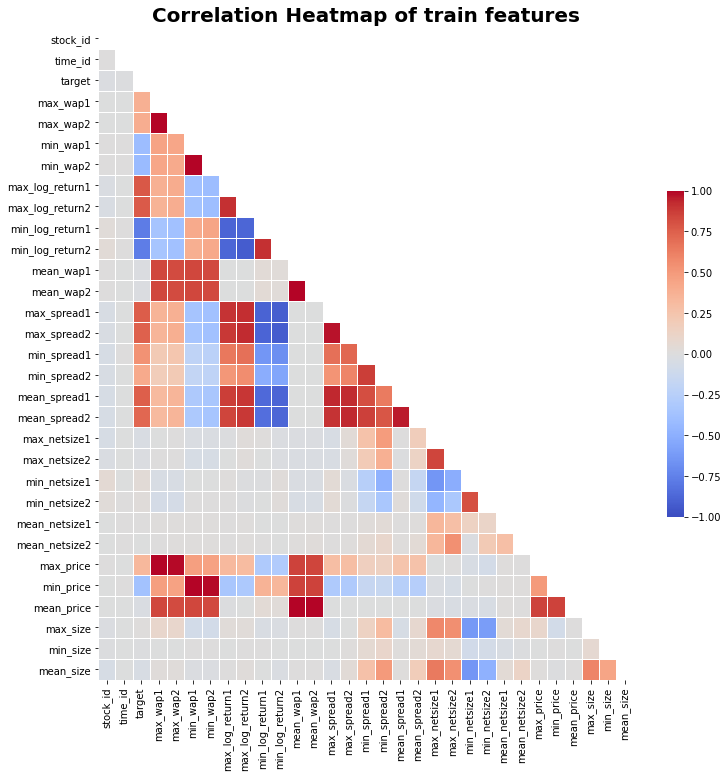

In [7]:
plt.figure(figsize = (12, 12))
corr = train_df.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap = 'coolwarm', mask = mask, linewidth = 0.5, vmin = -1, vmax = 1,
           cbar_kws = {'shrink': .5})
plt.title('Correlation Heatmap of train features', fontsize = 20, fontweight = 'bold')
plt.show()

In [8]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)

features = train_df.drop(['target'], axis = 1)
target = train_df['target']

# define LGBM model
lgbm = LGBMRegressor(random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size = 0.2, random_state = 0)

## Feature selection: Permutation Importance<a class="anchor" id="fs"></a>
Permutation Importance is useful feature selection method. Usually we generate as many variables as possible and then select variables with big importances to improve model performance. 

I selected 25 variables in this notebook! 

In [9]:
# feature selection - permutation importance
lgbm = LGBMRegressor(n_estimators = 1000, random_state = 0).fit(X_train, y_train)
perm = PermutationImportance(lgbm, random_state = 0).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
0.1270 ± 0.0027,mean_spread1
0.0818 ± 0.0016,min_log_return1
0.0772 ± 0.0018,max_log_return1
0.0588 ± 0.0012,min_price
0.0554 ± 0.0010,max_spread1
0.0531 ± 0.0013,max_price
0.0462 ± 0.0018,min_log_return2
0.0382 ± 0.0010,max_log_return2
0.0373 ± 0.0005,mean_spread2
0.0281 ± 0.0006,mean_size


In [10]:
# define selected features (25) 
feat_selected = eli5.explain_weights_df(perm, feature_names = features.columns.tolist(), top = 25)['feature']
new_features = train_df[feat_selected]

new_features

,mean_spread1,min_log_return1,max_log_return1,min_price,max_spread1,max_price,min_log_return2,max_log_return2,mean_spread2,mean_size,...,min_spread1,min_wap1,min_wap2,max_wap1,min_spread2,max_size,mean_wap2,max_netsize2,mean_netsize1,min_netsize1
0,0.000855,-0.000896,0.001049,1.002301,0.001396,1.004680,-0.001827,0.002112,0.001182,79.475000,...,0.000362,1.001443,1.001390,1.004920,0.000672,499.0,1.003668,380,4.438538,-225
1,0.000393,-0.000476,0.000396,0.999724,0.000903,1.000828,-0.000547,0.000773,0.000670,42.966667,...,0.000151,0.999700,0.999575,1.000834,0.000301,280.0,1.000208,302,78.688442,-263
2,0.000724,-0.000783,0.000799,0.997391,0.001149,1.000455,-0.001612,0.001436,0.001118,86.440000,...,0.000383,0.997224,0.996897,1.000878,0.000574,391.0,0.999682,322,-34.663102,-389
3,0.000861,-0.001296,0.000757,0.997972,0.001619,1.000231,-0.001601,0.000860,0.001161,130.800000,...,0.000324,0.997447,0.997430,1.000412,0.000648,450.0,0.998624,287,-8.436975,-293
4,0.000396,-0.000750,0.000912,0.999231,0.000792,1.000023,-0.000787,0.000914,0.000695,81.409091,...,0.000093,0.999231,0.999102,1.000159,0.000373,341.0,0.999624,303,31.120000,-228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.000877,-0.001228,0.001194,0.998465,0.001567,1.000522,-0.001287,0.001358,0.001170,69.459459,...,0.000392,0.998250,0.997950,1.000736,0.000457,528.0,0.999584,511,64.689320,-345
428928,0.000707,-0.001061,0.000906,1.000620,0.001379,1.005586,-0.000891,0.001260,0.000977,54.023256,...,0.000241,1.000633,1.000632,1.006166,0.000517,238.0,1.002610,275,63.806306,-205
428929,0.000738,-0.000875,0.000763,0.999605,0.001284,1.001837,-0.001372,0.001417,0.001120,106.857143,...,0.000148,0.999619,0.999515,1.002656,0.000444,498.0,1.000999,593,158.470588,-219
428930,0.000531,-0.000607,0.000967,1.000889,0.001119,1.002604,-0.000955,0.000925,0.000807,117.362500,...,0.000066,1.000627,1.000578,1.002963,0.000329,738.0,1.001794,365,-57.402010,-399


## Hyperparameter Tuning: Bayesian Optimization <a class="anchor" id="opt"></a>
To select optimal parameter, we need to conduct hyperparameter tuning.

**GridSearchCV** take too long since this tests all possible combinations of parameters. **RandomSearchCV** take less time but it chooses set of parameters randomly(does not test all combinations of parameters), selected parameter may not be an optimal parameter. Both algorithms do not contains prior knowledge information

**Bayesian Optimization** keep track of past evaluation results which they use to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function. Also it's fatster than GridSearchCV, and more precise than RandomSearchCV.
(Ref: <https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f>)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(new_features, target, test_size = 0.2, random_state = 0)


def lgbm_cv(learning_rate, n_estimators, max_depth, num_leaves, subsample, min_data_in_leaf, silent = True):
    params = {'learning_rate': learning_rate,
          'n_estimators': int(n_estimators),
          'max_depth': int(max_depth),
          'num_leaves': int(num_leaves),
          'subsample': subsample,
          'min_data_in_leaf': int(min_data_in_leaf),
          'verbose': -1,
          'force_col_wise': True
             }
    
    lgbm_train = lgb.Dataset(X_train, label = y_train, categorical_feature = ['stock_id'], weight = 1/np.square(y_train))
    lgbm_val = lgb.Dataset(X_val, label = y_val, categorical_feature = ['stock_id'], weight = 1/np.square(y_val))
    
    model = lgb.train(params = params,
                      train_set = lgbm_train,
                      valid_sets = lgbm_val,
                      feval = feval_RMSPE,
                      verbose_eval = False,
                      early_stopping_rounds = 100)
    
    pred = model.predict(X_val)
    rmspe_score = RMSPE(y_val, pred)
    
    return rmspe_score

In [12]:
pbounds = {'learning_rate': (0.05, 0.1),
          'n_estimators': (1000, 2000),
          'max_depth': (15, 20),
          'num_leaves': (7, 14),
          'subsample': (0.5, 0.9),
          'min_data_in_leaf': (10, 20)
          }

lgbm_bo = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 0)

# init_points :  initial number of Random Search points 
# n_iter : iteration number
# acq : Acquisition Function - we use EI
# xi : exploration (default: 0)
lgbm_bo.maximize(init_points = 2, n_iter = 10, acq = 'ei', xi = 0.01)

|   iter    |  target   | learni... | max_depth | min_da... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.2699   |  0.07744  |  18.58    |  16.03    |  1.545e+0 |  9.966    |  0.7584   |
|  2        |  0.2691   |  0.07188  |  19.46    |  19.64    |  1.383e+0 |  12.54    |  0.7116   |
|  3        |  0.2685   |  0.074    |  19.32    |  18.53    |  1.544e+0 |  9.821    |  0.5497   |
|  4        |  0.271    |  0.06278  |  17.65    |  11.34    |  1.982e+0 |  12.87    |  0.6258   |
|  5        |  0.2674   |  0.08029  |  15.06    |  16.15    |  1.413e+0 |  13.94    |  0.6697   |
|  6        |  0.2701   |  0.05771  |  15.61    |  11.2     |  1.974e+0 |  9.135    |  0.7046   |
|  7        |  0.2696   |  0.05826  |  15.95    |  14.64    |  1.896e+0 |  10.29    |  0.5763   |
|  8        |  0.2699   |  0.06089  |  18.83    |  15.69    |  1.64e+03 |  7.439    |  0.6298   |
|  9        |  0.27 

In [13]:
# optimal parameter
print(lgbm_bo.max)

opt_params = lgbm_bo.max['params']

{'target': 0.2710037854994331, 'params': {'learning_rate': 0.06277693495894175, 'max_depth': 17.65383750029189, 'min_data_in_leaf': 11.335662300960594, 'n_estimators': 1981.9773135001178, 'num_leaves': 12.873747488650498, 'subsample': 0.6257980522620717}}


In [14]:
# GridSearchCV

# scoring function
#rmspe = make_scorer(RMSPE, greater_is_better = False)

#X_train, X_val, y_train, y_val = train_test_split(new_features, target, test_size = 0.2, random_state = 0)

#grid_model = GridSearchCV(lgbm, param_grid = params, cv = 5, scoring = rmspe)
#grid_model.fit(X_train, y_train)

#print('Best parameter: ', grid_model.best_params_)
#print('Best score: ', grid_model.best_score_)

## LGBM Modeling <a class="anchor" id="model"></a>

In [15]:
params = {'learning_rate': opt_params['learning_rate'],
          'objective': 'regression',
          'n_estimators': int(np.round(opt_params['n_estimators'], 0)), 
          'max_depth': int(np.round(opt_params['max_depth'], 0)),
          'num_leaves': int(np.round(opt_params['num_leaves'], 0)),
          'min_data_in_leaf': int(np.round(opt_params['min_data_in_leaf'], 0)),
          'subsample': opt_params['subsample'],
          'force_col_wise': True,
          'verbose': -1
          }

    
# KFold
rmspe_list = []
for i, (train_idx, val_idx) in enumerate(kfold.split(new_features)):
    print(f'################# {i+1}th Fold #################')
    X_train, X_val = new_features.iloc[train_idx, :], new_features.iloc[val_idx, :]
    y_train, y_val = target[train_idx], target[val_idx]
        
    train_set = lgb.Dataset(X_train, label = y_train, categorical_feature = ['stock_id'], weight = 1/np.square(y_train))
    val_set = lgb.Dataset(X_val, label = y_val, categorical_feature = ['stock_id'], weight = 1/np.square(y_val))

    model = lgb.train(params = params,
                          train_set = train_set,
                          valid_sets = val_set,
                          feval = feval_RMSPE,
                          verbose_eval = False,
                          early_stopping_rounds = 100)
        
    pred = model.predict(X_val)
    rmspe_score = RMSPE(y_val, pred)
    print(f'RMSPE: {np.round(rmspe_score, 4)}')
    rmspe_list.append(rmspe_score)

################# 1th Fold #################
RMSPE: 0.2703
################# 2th Fold #################
RMSPE: 0.2684
################# 3th Fold #################
RMSPE: 0.2708
################# 4th Fold #################
RMSPE: 0.2697
################# 5th Fold #################
RMSPE: 0.2763


In [16]:
feat_imp = pd.DataFrame()
feat_imp['feature'] = new_features.columns.tolist()
feat_imp['importance'] = model.feature_importance(importance_type = 'gain')

feat_imp = feat_imp.sort_values(by = ['importance'], ascending = False).reset_index(drop = True)
feat_imp

,feature,importance
0,min_log_return1,176045.496057
1,max_log_return1,160442.896929
2,max_spread1,79448.421003
3,stock_id,67009.657706
4,min_log_return2,44005.996209
5,max_log_return2,36239.957499
6,min_wap1,17981.894680
7,max_wap1,16417.859401
8,max_wap2,14580.984836
9,min_wap2,13687.589113


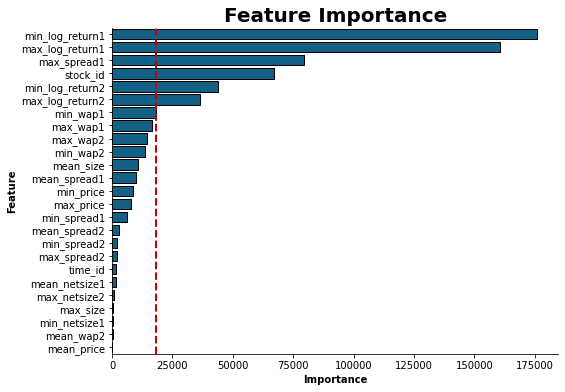

In [17]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(data = feat_imp, x = 'importance', y = 'feature', color = '#006699', edgecolor = 'black')
plt.axvline(x = feat_imp['importance'][6], linestyle = '--', color = '#cc0000', linewidth = 2)


for i in ['right', 'top']:
        ax.spines[i].set_visible(False)
        
plt.title('Feature Importance', fontsize = 20, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 10, fontweight = 'bold')
plt.ylabel('Feature', fontsize = 10, fontweight = 'bold')
plt.show()

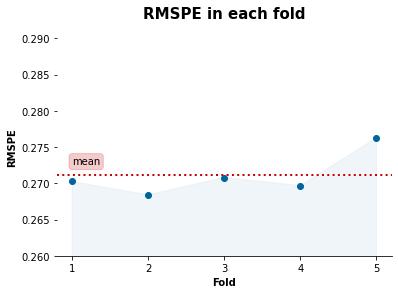

In [18]:
ax = plt.subplot(1, 1, 1)
#ax.plot(range(1, 6), rmspe_list, color ='#006699', marker = 'o')
ax.fill_between(range(1, 6), 0, rmspe_list, alpha = 0.4, color = '#d9e6f2')
ax.scatter(range(1, 6), rmspe_list, color = '#006699')
plt.axhline(y = np.mean(rmspe_list), color = '#cc0000', linestyle = ':', linewidth = 2)
plt.text(1 ,np.mean(rmspe_list)+0.0015, 'mean', 
         bbox = dict(facecolor ='#cc0000', edgecolor='#cc0000', boxstyle='round', alpha = 0.2))


ax.set_ylim([0.26, 0.29])
for i in ['left', 'right', 'top']:
        ax.spines[i].set_visible(False)

ax.set_xlabel('Fold', fontweight = 'bold')
ax.set_ylabel('RMSPE', fontweight = 'bold')
ax.set_xticks(range(1,6))
plt.title('RMSPE in each fold', fontsize = 15, fontweight = 'bold', pad = 20)
plt.show()

## Prediction & Submission <a class="anchor" id="pred"></a>

In [19]:
test_df_new = test_df.drop(['row_id'], axis = 1)
test_df_new = test_df[feat_selected]
test_pred = model.predict(test_df_new)

In [20]:
test_pred

array([0.00085157, 0.00218923, 0.00218923])

In [21]:
test_df['target'] = test_pred
sub = test_df[['row_id', 'target']]
sub

,row_id,target
0,0-4,0.000852
1,0-32,0.002189
2,0-34,0.002189


In [22]:
sub.to_csv('submission.csv', index = False)